# FixMatch


In [1]:
# deep learning
import torch
import torch.nn as nn
from torch.distributions.transforms import LowerCholeskyTransform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# vizualisation
import torchsummary

# torchvision
import torchvision
import torchvision.transforms as transforms

# plotting
import matplotlib.pyplot as plt
from torchview import draw_graph
from IPython.display import display
from IPython.core.display import SVG, HTML
from tqdm import tqdm

In [2]:
# Set device
if float(torch.__version__.split(".")[1]) >= 13 and torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

BATCH_SIZE = 32
IMG_SHAPE = (3, 32, 32)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
                                        
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
                                       
testloader = DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## RandAugment

Pour implémenter l'augmentation forte dans FixMatch, vous aurez besoin d'une politique d'augmentation de données apprise par renforcement. La méthode RandAugment a été implémentée dans la bibliothèque imgaug, voici comment l'utiliser


In [8]:
from torchvision.transforms import RandAugment

aug = RandAugment(num_ops= 2, magnitude=9)

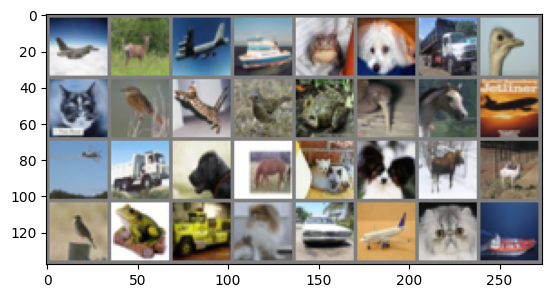

plane deer  plane ship  frog  dog   truck bird  cat   bird  cat   bird  frog  bird  horse plane plane truck dog   horse cat   dog   deer  deer  bird  frog  truck dog   car   plane cat   ship 


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

In [11]:
# implementation in PyTorch of a simple CNN

class ConvNN(nn.Module):
    """
    Simple CNN for CIFAR10
    """
    
    def __init__(self):
        super().__init__()
        self.conv_32 = nn.Conv2d(3, 32, kernel_size=3, padding='same')
        self.conv_64 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv_96 = nn.Conv2d(64, 96, kernel_size=3, padding='same')
        self.conv_128 = nn.Conv2d(96, 128, kernel_size=3, padding='same')
        self.fc_512 = nn.Linear(512, 512)
        self.fc_10 = nn.Linear(512, 10)
        self.max_pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU(inplace=True)
        self.soft_max = nn.Softmax(dim=1)
        self.flatten = nn.Flatten()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_32(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_64(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_96(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_128(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.flatten(x)
        x = self.fc_512(x)
        x = self.relu(x)
        x = self.fc_10(x)
        x = self.soft_max(x)
        return x

model = ConvNN().to(device)

In [12]:
model_graph = draw_graph(model, input_size=[(BATCH_SIZE, *IMG_SHAPE)], graph_name='./figures/model', graph_dir="LR", device='cpu', expand_nested=True, save_graph=True)

display(
    HTML("<h2>Model</h2>"),
    SVG(model_graph.visual_graph._repr_image_svg_xml()),
)

In [13]:
EPOCHS = 1000

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
criterion = nn.CrossEntropyLoss()

for epoch in (pbar := tqdm(range(EPOCHS))):

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # extract mini batch
        images, labels = data

        # forward pass
        outputs = model.forward(images)
        loss = criterion.forward(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # update weights and lr
        optimizer.step()
        scheduler.step()
        
        # update metrics
        running_loss += loss.item()
    
    # print statistics
    pbar.set_description_str(f"Epoch {epoch: >5}")
    pbar.set_postfix(
        {
            "train_loss": f"{running_loss:.2f}",
            "lr": f"{optimizer.param_groups[0]['lr']:.3f}",
        }
    )



Epoch     3:   0%|          | 4/1000 [04:22<18:02:17, 65.20s/it, train_loss=3598.61, lr=0.001]